### 必要なライブラリのインポート

In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler

### CSVファイルの読み込み

In [14]:
# CSVファイルの読み込み
df = pd.read_csv('ks-projects-201801.csv')
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


In [15]:
print(len(df))

378661


In [16]:
# 統計量の算出
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### 欠損値の処理

In [17]:
# 欠損値の確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [18]:
# 暫定で０埋めにする
df['usd pledged'] = df['usd pledged'].fillna('0')
df.isnull().sum()

ID                  0
name                4
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

### ダミー変数の作成

### 日付データの処理

In [19]:
# 日付型に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched']).dt.strftime('%Y-%m-%d'))

In [20]:
# launched と deadline の差をとって、日数を計算
df['datenum'] = (df['deadline']-df['launched']).astype('timedelta64[D]')

### 目的変数の処理

In [21]:
df.loc[df['state'] == 'successful', 'state_num'] = 1
df.loc[df['state'] != 'successful', 'state_num'] = 0

### カテゴリ値の処理

In [22]:
# カテゴリ値の種別を確認
vc = df['category'].value_counts()
print(vc)
print(type(vc))

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Makerspaces            238
Printing               238
M

In [23]:
df_wk = df.loc[:,['category', 'state_num']]
df_wk = df_wk[df_wk['category'].isin(['Product Design' , 'Documentary', 'Music', 'Tabletop Games', 'Shorts', 'Video Games', 'Food', 'Film & Video'])]
len(df_wk)

114148

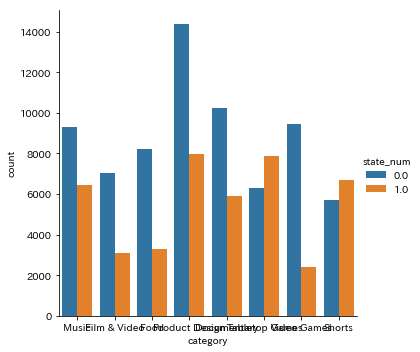

In [24]:
sns.catplot(x="category", hue="state_num", data=df_wk, kind="count")

In [25]:
#categoryは特定カテゴリ値での相関が強すぎる結果はないはず

In [26]:
vc = df['main_category'].value_counts()
print(vc)
print(type(vc))

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64
<class 'pandas.core.series.Series'>


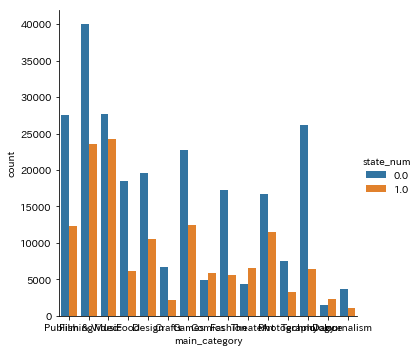

In [27]:
sns.catplot(x="main_category", hue="state_num", data=df, kind="count")

In [28]:
# main_categoryは特定カテゴリ値での相関が強すぎる結果はないはず

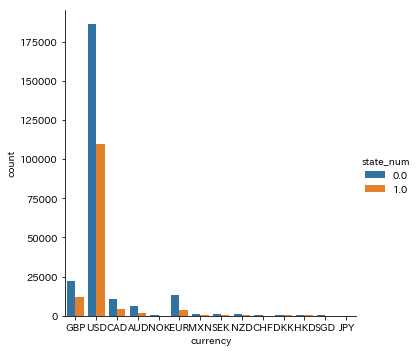

In [29]:
sns.catplot(x="currency", hue="state_num", data=df, kind="count")

In [30]:
# currencyは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSDしかないのであれば説明変数で不要か

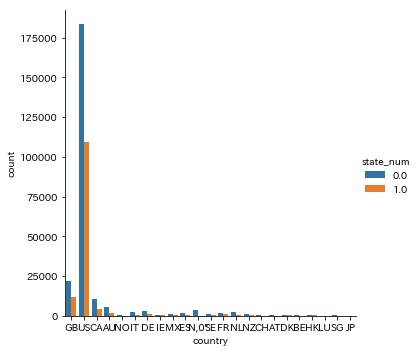

In [31]:
sns.catplot(x="country", hue="state_num", data=df, kind="count")

In [32]:
# countryは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSAしかないのであれば説明変数で不要か

In [33]:
# OneHotEncoding
#df_OneHot = pd.get_dummies(df, columns=['category','main_category','currency','country'])
#df = pd.get_dummies(df, columns=['category','main_category'])
#df.describe()

In [34]:
# カテゴリ値版
# categoryをカテゴリ値に変換
labels, uniques = pd.factorize(df['category'])
df['category'] = labels

# main_categoryをカテゴリ値に変換
labels, uniques = pd.factorize(df['main_category'])
df['main_category'] = labels

df.describe()

# OneHotエンコーディングすると学習が終わらないので、いったんカテゴリ値で代用する

,ID,category,main_category,goal,pledged,backers,usd_pledged_real,usd_goal_real,datenum,state_num
count,3.786610e+05,378661.000000,378661.000000,3.786610e+05,3.786610e+05,378661.000000,3.786610e+05,3.786610e+05,378661.000000,378661.000000
mean,1.074731e+09,38.764401,4.964591,4.908079e+04,9.682979e+03,105.617476,9.058924e+03,4.545440e+04,34.481095,0.353762
std,6.190862e+08,34.478769,4.105380,1.183391e+06,9.563601e+04,907.185035,9.097334e+04,1.152950e+06,65.909173,0.478137
min,5.971000e+03,0.000000,0.000000,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,1.000000,0.000000
25%,5.382635e+08,9.000000,1.000000,2.000000e+03,3.000000e+01,2.000000,3.100000e+01,2.000000e+03,30.000000,0.000000
50%,1.075276e+09,30.000000,4.000000,5.200000e+03,6.200000e+02,12.000000,6.243300e+02,5.500000e+03,30.000000,0.000000
75%,1.610149e+09,55.000000,8.000000,1.600000e+04,4.076000e+03,56.000000,4.050000e+03,1.550000e+04,37.000000,1.000000
max,2.147476e+09,158.000000,14.000000,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,16739.000000,1.000000


### 説明変数・目的変数の取り出し（１回目）

In [35]:
# 不要な説明変数の設定
#drop_col = ['ID', 'name','deadline','launched','state']
drop_col = ['ID', 'currency', 'country', 'name','deadline','launched','state','backers']
# backers は投資された人数の結果値なので、予測値に投入してはいけない

In [36]:
# 不要列の削除
df=df.drop(drop_col, axis=1)
df.head(3)

,category,main_category,goal,pledged,usd pledged,usd_pledged_real,usd_goal_real,datenum,state_num
0,0,0,1000.0,0.0,0,0.0,1533.95,59.0,0.0
1,1,1,30000.0,2421.0,100,2421.0,30000.00,60.0,0.0
2,1,1,45000.0,220.0,220,220.0,45000.00,45.0,0.0


### 説明変数間の相関を確認

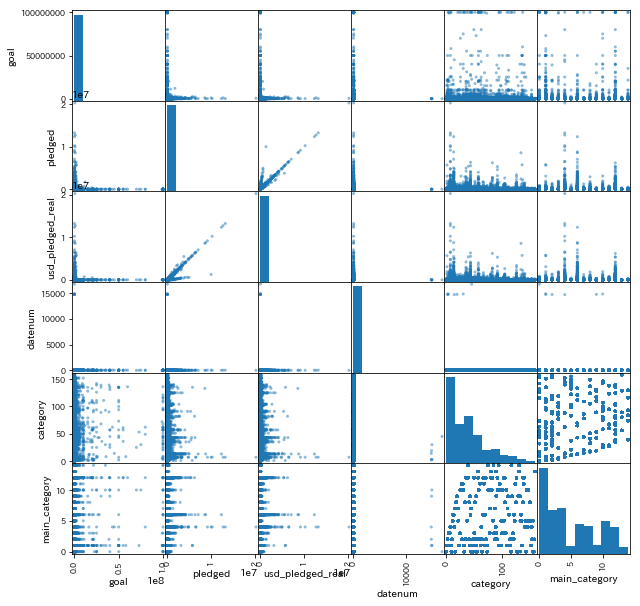

In [38]:
#df_wk = df.loc[:,['goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'datenum', 'category', 'main_category']]
df_wk = df.loc[:,['goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'datenum', 'category', 'main_category']]
pd.plotting.scatter_matrix(df_wk, figsize=(10,10))
plt.show()

# メモリ食うので削除
#del df_wk

In [39]:
# pledged と usd_pledged_realが相関が強すぎるので、片方消す
drop_col2 = ['usd_pledged_real']
df=df.drop(drop_col2, axis=1)

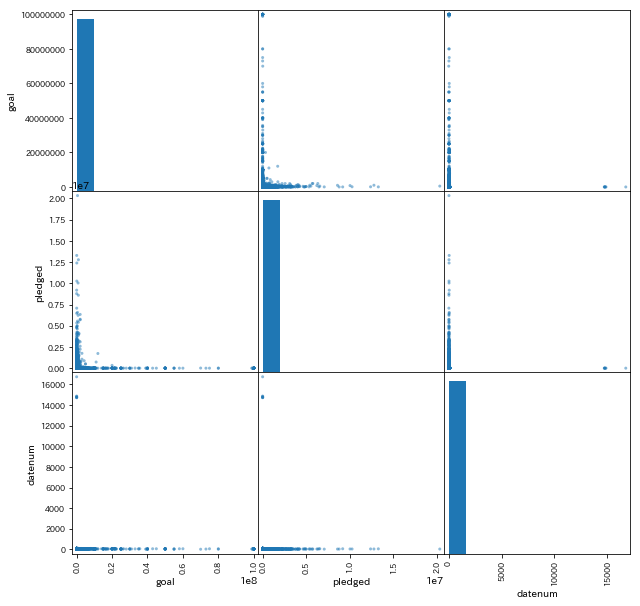

In [40]:
# もう一回確認
df_wk = df.loc[:,['goal', 'pledged', 'usd pledged', 'datenum']]
pd.plotting.scatter_matrix(df_wk, figsize=(10,10))
plt.show()

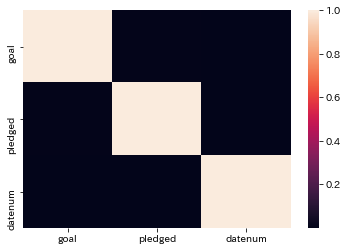

In [41]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_wk.corr())
plt.show()

# メモリ食うので削除
del df_wk

In [42]:
# いったん使用する説明変数はここで確定

### 外れ値の確認

goal          AxesSubplot(0.125,0.125;0.227941x0.755)
pledged    AxesSubplot(0.398529,0.125;0.227941x0.755)
datenum    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

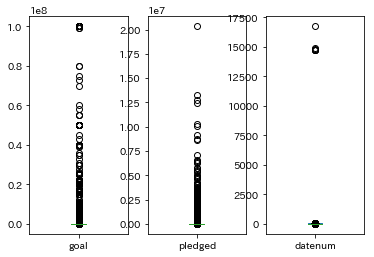

In [43]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'pledged', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

In [44]:
# 明らかに変な図

In [45]:
# 統計量を再確認する
df_wk.describe()

,goal,pledged,datenum
count,3.786610e+05,3.786610e+05,378661.000000
mean,4.908079e+04,9.682979e+03,34.481095
std,1.183391e+06,9.563601e+04,65.909173
min,1.000000e-02,0.000000e+00,1.000000
25%,2.000000e+03,3.000000e+01,30.000000
50%,5.200000e+03,6.200000e+02,30.000000
75%,1.600000e+04,4.076000e+03,37.000000
max,1.000000e+08,2.033899e+07,16739.000000


In [46]:
# 多分はずれ値ありそう

In [47]:
# 3σで削除する関数定義
def sigma3(df, col):
    mean = df[col].mean()
    sigma = df[col].std()
    low = mean - 3 * sigma
    high = mean + 3 * sigma
    df = df[(df[col]>low) & (df[col]<high)]
    sns.distplot(df[col])
    return df

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


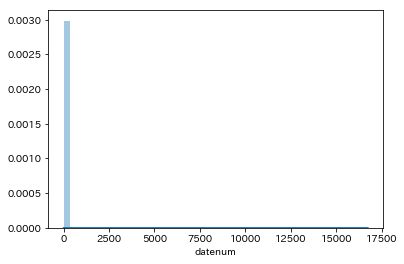

In [48]:
# datenum から処理
col = 'datenum'

# 現状の散布図確認
sns.distplot(df[col])

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


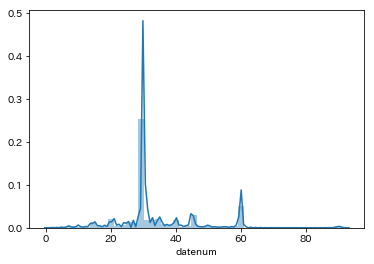

In [49]:
df = sigma3(df, col)

In [50]:
# おさまったっぽいのでこれでOK

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


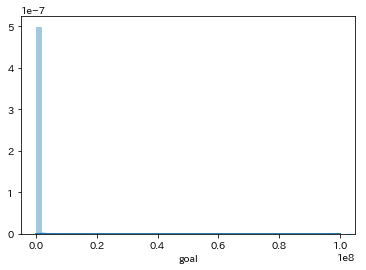

In [51]:
# datenum から処理
col = 'goal'

# 現状の散布図確認
sns.distplot(df[col])

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


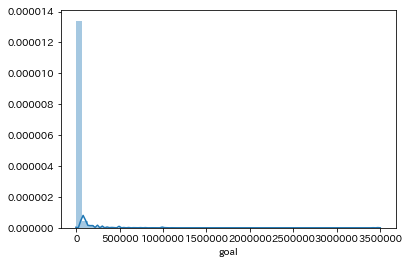

In [52]:
df = sigma3(df, col)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


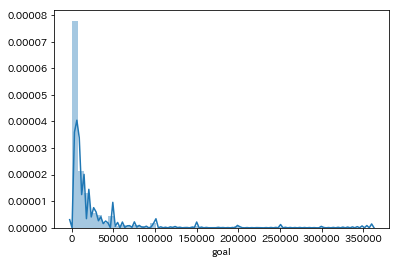

In [53]:
df = sigma3(df, col)

In [54]:
# おさまったっぽいのでこれでOK

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


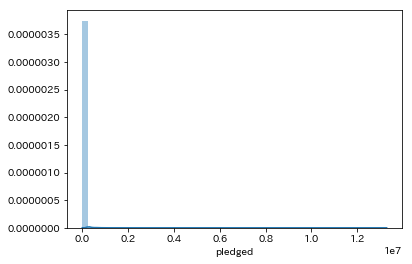

In [55]:
# pledged 処理
col = 'pledged'

# 現状の散布図確認
sns.distplot(df[col])

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


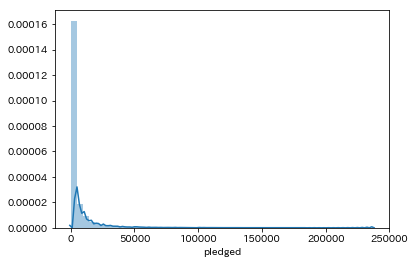

In [56]:
df = sigma3(df, col)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


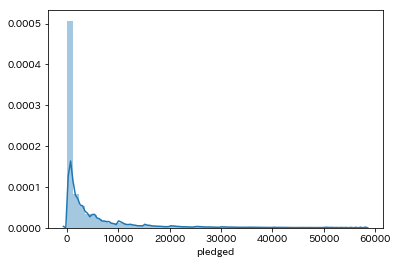

In [57]:
df = sigma3(df, col)

In [58]:
# おさまったっぽいのでこれでOK

goal          AxesSubplot(0.125,0.125;0.227941x0.755)
pledged    AxesSubplot(0.398529,0.125;0.227941x0.755)
datenum    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

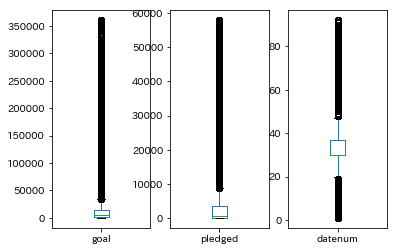

In [59]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'pledged', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

In [60]:
# まぁそれなりっぽくなったので、これでOK？
len(df)

365691

In [61]:
# 件数 378661→365691

In [62]:
del df_wk

### データ分割

In [63]:
# 説明変数と目的変数のデータ準備
y = df['state_num'].values
X = df.drop('state_num', axis=1).values

### ホールドアウト

In [75]:
# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

292552 292552


### 交差検定

In [81]:
#X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_log_loss = 0
cross_valid_accuracy_score = 0
split_num = 1
stdsc = StandardScaler()

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train):
    X_train_kf, y_train_kf = X_train[train_idx], y_train[train_idx] #学習用データ
    X_test_kf, y_test_kf = X_train[test_idx], y_train[test_idx]     #テスト用データ
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))

    # データを標準化
    X_train_kf = stdsc.fit_transform(X_train_kf)
    X_test_kf = stdsc.fit_transform(X_test_kf)
    
    print(len(X_train_kf),len(y_train_kf),len(X_test_kf),len(y_test_kf))
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train_kf, y_train_kf)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_kf)
    
    print(len(X_test_kf),len(y_test_kf),len(y_pred_test))
    
    # 対数尤度を表示
    ls = log_loss(y_test_kf, y_pred_test)
    #print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_test)))
    print('対数尤度 = {:.3f}'.format(- ls))
    
    acs = accuracy_score(y_test_kf, y_pred_test)
    # 正答率を表示
    #print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
    print('正答率 = {:.3f}%'.format(100 * acs))
    
    # テストデータに対するMAEを計算
    print("Fold %s"%split_num)
    print()
    
    cross_valid_log_loss += ls #後で平均を取るためにMAEを加算
    cross_valid_accuracy_score += acs #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
print("Cross Validation logloss = %s"%round(cross_valid_log_loss / n_split, 3))
print("Cross Validation accuracy score = %s"%round(cross_valid_accuracy_score / n_split, 3))

234041 234041 58511 58511
234041 234041 58511 58511
58511 58511 58511
対数尤度 = -0.592
正答率 = 98.286%
Fold 1

234041 234041 58511 58511
234041 234041 58511 58511
58511 58511 58511
対数尤度 = -0.702
正答率 = 97.968%
Fold 2

234042 234042 58510 58510
234042 234042 58510 58510
58510 58510 58510
対数尤度 = -0.661
正答率 = 98.086%
Fold 3

234042 234042 58510 58510
234042 234042 58510 58510
58510 58510 58510
対数尤度 = -0.987
正答率 = 97.142%
Fold 4

234042 234042 58510 58510
234042 234042 58510 58510
58510 58510 58510
対数尤度 = -0.512
正答率 = 98.516%
Fold 5

Cross Validation logloss = 0.691
Cross Validation accuracy score = 0.98


### 予測実施

In [94]:
# カテゴリ値版
y = df_category['state_num'].values
X = df_category.drop('state_num', axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
w8 = clf.coef_[0, 7]
w9 = clf.coef_[0, 8]
w10 = clf.coef_[0, 9]
w11 = clf.coef_[0, 10]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}, w10 = {:.3f}, w11 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11))


w0 = 41.247, w1 = 1380.681, w2 = -481.008, w3 = -100.804, w4 = -361.775, w5 = 309.246, w6 = 2373.372, w7 = -2303.177, w8 = 89.787, w9 = 96.586, w10 = -49.394, w11 = -1751.374


In [95]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -0.669
正答率 = 98.064%


In [96]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = リノベーションなし', '正解 = リノベーション済み'], 
                        columns=['予測 = リノベーションなし', '予測 = リノベーション済み'])
conf_mat

,予測 = リノベーションなし,予測 = リノベーション済み
正解 = リノベーションなし,239326,5379
正解 = リノベーション済み,1950,132006
